In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, LayerNormalization, Dense, TimeDistributed, RepeatVector, MultiHeadAttention, Concatenate, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras import mixed_precision
import keras_tuner as kt
import matplotlib.pyplot as plt

mixed_precision.set_global_policy('mixed_float16')

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

df = pd.read_csv("dataset.csv")

df['timestamp'] = pd.to_datetime(df['id'], errors='coerce')
df.set_index('timestamp', inplace=True)

cols = [
    "humid",
    "ws100",
    "wdisp100",
]
df_for_training = df[cols].astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled = scaler.fit_transform(df_for_training)

sequence_length = 48  
prediction_length = 6 

GPU is available


In [55]:
X, y = [], []

for i in range(len(df_for_training_scaled) - sequence_length - prediction_length + 1):
    X.append(df_for_training_scaled[i: i + sequence_length])
    y.append(df_for_training_scaled[i + sequence_length + prediction_length -1, 1])  # 'ws100' está na coluna 1

X = np.array(X)
y = np.array(y)

print(f"Shape of X: {X.shape}")  
print(f"Shape of y: {y.shape}") 

Shape of X: (7508, 48, 3)
Shape of y: (7508,)


In [56]:
# Divisão em Conjuntos de Treino e Teste
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(f"Training set shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Test set shape: {X_test.shape}, y_test shape: {y_test.shape}")

Training set shape: (6006, 48, 3), y_train shape: (6006,)
Test set shape: (1502, 48, 3), y_test shape: (1502,)


In [57]:
# %%
# Calcular a média e o desvio padrão de ws100 no conjunto de treino escalonado
mu_scaled = np.mean(y_train)
sigma_scaled = np.std(y_train)

print(f"μ (mu_scaled): {mu_scaled:.4f}, σ (sigma_scaled): {sigma_scaled:.4f}")

μ (mu_scaled): 0.5679, σ (sigma_scaled): 0.1261


In [58]:
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.losses import Loss

@register_keras_serializable()
class WeightedMSE(Loss):
    def __init__(self, mu, sigma, **kwargs):
        super().__init__(**kwargs)
        self.mu = mu
        self.sigma = sigma

    def call(self, y_true, y_pred):
        # Remover dimensões extras se necessário
        y_true = tf.squeeze(y_true, axis=-1)  # Shape: (batch_size, 1)
        y_pred = tf.squeeze(y_pred, axis=-1)  # Shape: (batch_size, 1)
        
        # Calcular o expoente da PDF da Gaussiana
        exponent = -0.5 * tf.square((y_true - self.mu) / self.sigma)
        
        # Calcular a PDF da Gaussiana
        pdf = (1.0 / (self.sigma * tf.sqrt(2.0 * np.pi))) * tf.exp(exponent)
        
        # Calcular os pesos: maior para valores raros
        weights = 1.0 / (pdf + 1e-7)
        
        # Normalizar os pesos para ter média 1
        weights /= tf.reduce_mean(weights)
        
        # Calcular o MSE
        mse = tf.square(y_true - y_pred)
        
        # Aplicar os pesos
        weighted_mse = mse * weights
        
        # Calcular a perda média
        loss = tf.reduce_mean(weighted_mse)
        
        return loss

    def get_config(self):
        config = super().get_config()
        config.update({
            "mu": self.mu,
            "sigma": self.sigma
        })
        return config

In [59]:
def build_model_cnn_lstm_sixth_step(hp, mu, sigma):
    """
    Função para construir o modelo CNN-LSTM otimizado com Keras Tuner para prever o sexto passo de ws100.
    
    Args:
        hp: Hiperparâmetros definidos pelo Keras Tuner.
        mu (float): Média dos valores de ws100 no conjunto de treino escalonado.
        sigma (float): Desvio padrão dos valores de ws100 no conjunto de treino escalonado.
        
    Returns:
        model: Modelo compilado pronto para o treinamento.
    """
    # Hiperparâmetros com espaços de busca definidos
    filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    kernel_size = hp.Choice('kernel_size', values=[3, 5, 7])
    pool_size = hp.Choice('pool_size', values=[2, 3])
    units = hp.Int('units', min_value=32, max_value=128, step=32)
    learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3])
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)  # Permitir até 3 camadas
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    
    # Seleção do Otimizador com Gradient Clipping
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, clipnorm=1.0)
    
    # Definição do Input
    encoder_inputs = tf.keras.Input(shape=(sequence_length, X_train.shape[2]), name='encoder_input')  # 36 passos de entrada
    x = encoder_inputs
    
    # Camada CNN (Conv1D)
    x = Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        activation='relu',
        padding='same',
        kernel_regularizer=l2(1e-4),
        name='conv1d_layer'
    )(x)
    
    # Camada de Pooling (MaxPooling1D)
    x = MaxPooling1D(pool_size=pool_size, padding='same', name='maxpool_layer')(x)
    
    # Camadas LSTM
    for i in range(num_layers):
        # Define return_sequences=True para todas as camadas LSTM intermediárias
        return_sequences = True if i < (num_layers - 1) else False
        x = LSTM(
            units=units,
            return_sequences=return_sequences,
            activation='tanh',
            dropout=dropout_rate,
            kernel_regularizer=l2(1e-3),
            name=f'lstm_layer_{i}'
        )(x)
        x = LayerNormalization(name=f'lstm_norm_{i}')(x)
    
    # Camada Dense para prever o sexto passo de ws100
    outputs = Dense(1, activation='linear', name='output_layer')(x)  # Shape: [batch_size, 1]
    
    # Definição do Modelo
    model = Model(inputs=encoder_inputs, outputs=outputs, name='Wind_Speed_Predictor_Sixth_Step')
    
    # Compilação do Modelo com a Função de Perda Customizada
    model.compile(
        optimizer=optimizer,
        loss=WeightedMSE(mu=mu, sigma=sigma),  # Usando a classe de perda customizada
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            tf.keras.metrics.MeanAbsoluteError(name='mae')        
        ]
    )
    
    return model

In [60]:
def build_model_cnn_lstm_recursive(hp):
    """
    Função para construir o modelo CNN-LSTM otimizado com Keras Tuner para previsão do sexto passo de ws100.
    
    Args:
        hp: Hiperparâmetros definidos pelo Keras Tuner.
        
    Returns:
        model: Modelo compilado pronto para o treinamento.
    """
    # Hiperparâmetros com espaços de busca definidos
    filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    kernel_size = hp.Choice('kernel_size', values=[3, 5, 7])
    pool_size = hp.Choice('pool_size', values=[2, 3])
    units = hp.Int('units', min_value=32, max_value=128, step=32)
    learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3])
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)  # Permitir até 3 camadas
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    
    # Seleção do Otimizador com Gradient Clipping
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, clipnorm=1.0)
    
    # Definição do Input
    encoder_inputs = tf.keras.Input(shape=(sequence_length, X_train.shape[2]), name='encoder_input')  # 36 passos de entrada
    x = encoder_inputs
    
    # Camada CNN (Conv1D)
    x = Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        activation='relu',
        padding='same',
        kernel_regularizer=l2(1e-4),
        name='conv1d_layer'
    )(x)
    
    # Camada de Pooling (MaxPooling1D)
    x = MaxPooling1D(pool_size=pool_size, padding='same', name='maxpool_layer')(x)
    
    # Camadas LSTM
    for i in range(num_layers):
        # Define return_sequences=True para todas as camadas LSTM intermediárias
        return_sequences = True if i < (num_layers - 1) else False
        x = LSTM(
            units=units,
            return_sequences=return_sequences,
            activation='tanh',
            dropout=dropout_rate,
            kernel_regularizer=l2(1e-3),
            name=f'lstm_layer_{i}'
        )(x)
        x = LayerNormalization(name=f'lstm_norm_{i}')(x)
    
    # Camada Dense para prever o sexto passo de ws100
    outputs = Dense(1, activation='linear', name='output_layer')(x)  # Shape: [batch_size, 1]
    
    # Definição do Modelo
    model = Model(inputs=encoder_inputs, outputs=outputs, name='Wind_Speed_Predictor_Sixth_Step')
    
    # Compilação do Modelo
    model.compile(
        optimizer=optimizer,
        loss='mse',  # Usando MSE padrão
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            tf.keras.metrics.MeanAbsoluteError(name='mae')        
        ]
    )
    
    return model


In [61]:
from functools import partial

build_model_partial = partial(build_model_cnn_lstm_sixth_step, mu=mu_scaled, sigma=sigma_scaled)

# %%
# Inicialização do Keras Tuner com Hyperband Otimizado
tuner = kt.Hyperband(
    build_model_partial,                          # Função parcial de construção do modelo
    objective='val_loss',                         # Métrica a ser minimizada
    max_epochs=10,                                # Número máximo de épocas
    factor=3,                                     # Fator de redução no número de épocas
    directory='tuner_dir_sixth_step',             # Diretório para salvar os resultados do tuner
    project_name='wind_speed_prediction_sixth_step',  # Nome do projeto
    overwrite=True                                # Sobrescrever os resultados anteriores
)

# %%
# Definição dos Callbacks

# EarlyStopping para interromper o treinamento quando a validação não melhora
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Número de épocas sem melhora antes de interromper
    restore_best_weights=True
)

# ReduceLROnPlateau para reduzir a taxa de aprendizado quando a validação não melhora
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,     # Fator pelo qual a taxa de aprendizado será reduzida
    patience=3,     # Número de épocas sem melhora antes de reduzir
    min_lr=1e-5     # Taxa de aprendizado mínima
)

# TensorBoard para monitoramento visual do treinamento
tensorboard_callback = TensorBoard(log_dir='./logs_sixth_step', histogram_freq=1)

# ModelCheckpoint para salvar o melhor modelo baseado na validação
checkpoint = ModelCheckpoint(
    'best_model_sixth_step.h5.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)


In [62]:
batch_size = 128  # Ajuste conforme a capacidade da sua GPU
# %%
# Converter dados para Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle, batch e prefetch para otimização
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Pipeline de dados configurado.")

Pipeline de dados configurado.


In [63]:
# %%
# Executando a Busca de Hiperparâmetros
tuner.search(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,  # Número máximo de épocas para cada trial
    callbacks=[early_stopping, reduce_lr, tensorboard_callback, checkpoint]
)

# %%
# Obtenção dos Melhores Hiperparâmetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Melhores hiperparâmetros encontrados: {best_hps.values}")

Trial 2 Complete [00h 00m 03s]

Best val_loss So Far: None
Total elapsed time: 00h 00m 07s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
32                |64                |filters
3                 |5                 |kernel_size
3                 |2                 |pool_size
64                |32                |units
0.001             |0.001             |learning_rate
0.3               |0.3               |dropout_rate
3                 |2                 |num_layers
adam              |rmsprop           |optimizer
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


2024-11-04 01:29:52.539572: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 17301653195070612
2024-11-04 01:29:52.539609: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 10302345224793083358
2024-11-04 01:29:52.539617: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 11831795835093774052
Traceback (most recent call last):
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tu

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InvalidArgumentError: Graph execution error:

Detected at node compile_loss/weighted_mse/Squeeze defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_122107/2914685478.py", line 3, in <module>

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 234, in search

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 54, in train_step

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 398, in _compute_loss

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 366, in compute_loss

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 618, in __call__

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 659, in call

  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/losses/loss.py", line 60, in __call__

  File "/tmp/ipykernel_122107/980519397.py", line 13, in call

Can not squeeze dim[0], expected a dimension of 1, got 128
	 [[{{node compile_loss/weighted_mse/Squeeze}}]] [Op:__inference_one_step_on_iterator_2717049]


In [ ]:
# Construção do Melhor Modelo
best_model = tuner.hypermodel.build(best_hps)

# Treinamento Final do Modelo com os Melhores Hiperparâmetros
history = best_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100  # Número de épocas para o treinamento final
)

# %%
best_model.save('best_model_sixth_step_final.h5.keras')
print("Melhor modelo salvo como 'best_model_sixth_step_final.h5.keras'.")

# Carregamento do Melhor Modelo (se necessário)
best_model = tf.keras.models.load_model(
    'best_model_sixth_step_final.h5.keras'
    )
print("Melhor modelo carregado para inferência.")


Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.5744 - mae: 1.3682 - rmse: 1.8136 - val_loss: 0.3469 - val_mae: 0.4237 - val_rmse: 0.4507
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3062 - mae: 0.4001 - rmse: 0.4295 - val_loss: 0.2352 - val_mae: 0.3801 - val_rmse: 0.4022
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2145 - mae: 0.3044 - rmse: 0.3484 - val_loss: 0.1659 - val_mae: 0.3010 - val_rmse: 0.3269
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1765 - mae: 0.2772 - rmse: 0.3289 - val_loss: 0.1285 - val_mae: 0.1948 - val_rmse: 0.2179
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1468 - mae: 0.2124 - rmse: 0.2553 - val_loss: 0.0672 - val_mae: 0.1558 - val_rmse: 0.1827
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0901 - mae: 0.1840 - rmse: 0.2194 - val_loss: 0.0492 - val_mae: 0.1088 - val_rmse: 0.1356
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0916 - mae: 0.1665 - rmse:

TypeError: Could not locate function 'loss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'loss', 'registered_name': 'function'}

In [ ]:
def inverse_scale(y_scaled, scaler):
    """
    Inverte a escala dos dados preditivos para o espaço original.
    
    Args:
        y_scaled: Array numpy de dados escalados, shape (num_samples,)
        scaler: Instância do MinMaxScaler utilizada para escalar os dados
        
    Returns:
        y_orig: Array numpy de dados no espaço original, shape (num_samples,)
    """
    # Supondo que 'ws100' é a segunda feature (index 1)
    feature_index = 1  # Ajuste se 'ws100' estiver em outro índice
    num_features = scaler.scale_.shape[0]
    
    # Reshape para [num_samples, 1]
    y_scaled_reshaped = y_scaled.reshape(-1, 1)
    
    # Criar arrays de zeros para as outras features
    zeros_before = np.zeros((y_scaled_reshaped.shape[0], feature_index))
    zeros_after = np.zeros((y_scaled_reshaped.shape[0], num_features - feature_index - 1))
    
    # Concatenar zeros antes, y_scaled e zeros depois
    y_scaled_full = np.concatenate([zeros_before, y_scaled_reshaped, zeros_after], axis=1)
    
    # Inverter a escala
    y_orig_full = scaler.inverse_transform(y_scaled_full)
    
    # Extrair a feature de interesse
    y_orig = y_orig_full[:, feature_index]
    
    return y_orig


Melhor modelo salvo como 'best_model_sixth_step_final.h5.keras'.


TypeError: Could not locate function 'loss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'loss', 'registered_name': 'function'}

In [ ]:
# %%
# Realização das Previsões no Conjunto de Teste
y_pred_scaled = best_model.predict(X_test)  # Shape: (num_samples, 1)

# Inversão da Escala das Previsões
y_pred_orig = inverse_scale(y_pred_scaled.flatten(), scaler)  # Shape: (num_samples,)

print("Previsões realizadas e escalas invertidas.")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Previsões realizadas e escalas invertidas.


In [ ]:
# %%
# Inversão da Escala dos Dados Reais
y_test_orig = inverse_scale(y_test, scaler)  # Shape: (num_samples,)

print("Inversão da escala dos dados reais concluída.")

Inversão da escala dos dados reais concluída.


RMSE: 1.1688
MAE: 0.9109


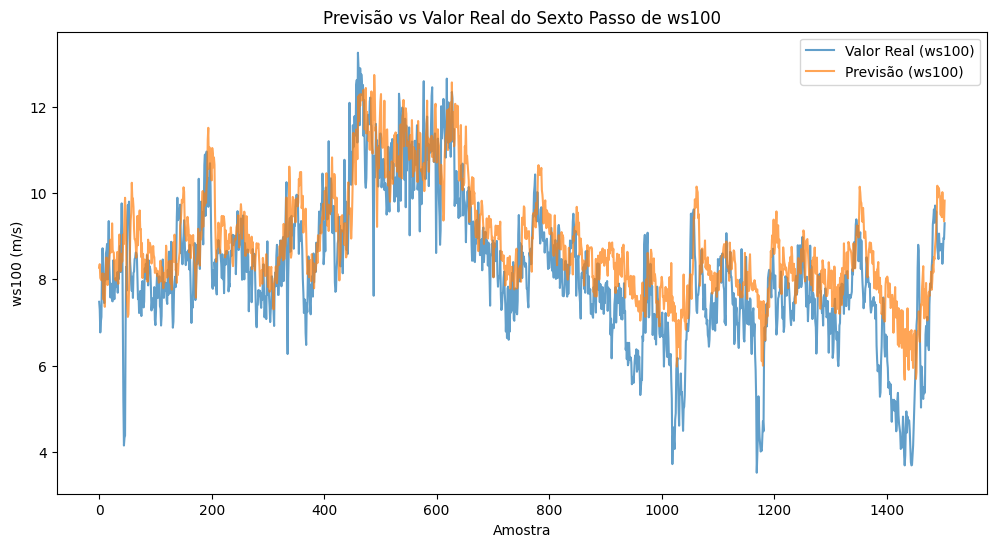

In [ ]:
# %%
# Avaliação e Visualização

from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae = mean_absolute_error(y_test_orig, y_pred_orig)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Visualização das Previsões vs. Valores Reais
plt.figure(figsize=(12,6))
plt.plot(y_test_orig, label='Valor Real (ws100)', alpha=0.7)
plt.plot(y_pred_orig, label='Previsão (ws100)', alpha=0.7)
plt.legend()
plt.title('Previsão vs Valor Real do Sexto Passo de ws100')
plt.xlabel('Amostra')
plt.ylabel('ws100 (m/s)')
plt.show()


In [ ]:
# Load the Best Model
best_model = tf.keras.models.load_model('best_model.h5.keras', custom_objects={'custom_loss': custom_loss})

# Make Predictions
y_pred = best_model.predict(X_test)

# Inverse Scaling
y_pred_flat = y_pred.reshape(-1, 1)
y_pred_orig = scaler.inverse_transform(np.concatenate([np.zeros_like(y_pred_flat), y_pred_flat, np.zeros_like(y_pred_flat)], axis=1))[:, 1]
y_pred_orig = y_pred_orig.reshape(-1, prediction_length)

y_test_flat = y_test[:, :, 0].reshape(-1, 1)
y_test_orig = scaler.inverse_transform(np.concatenate([np.zeros_like(y_test_flat), y_test_flat, np.zeros_like(y_test_flat)], axis=1))[:, 1]
y_test_orig = y_test_orig.reshape(-1, prediction_length)

ValueError: Input 0 of layer "Wind_Speed_Predictor_CNN_LSTM" is incompatible with the layer: expected shape=(None, 72, 3), found shape=(32, 36, 3)

Evaluation for time step 1
'ws100': RMSE = 0.9452, NRMSE = 0.0971, Relative Error = 9.94%


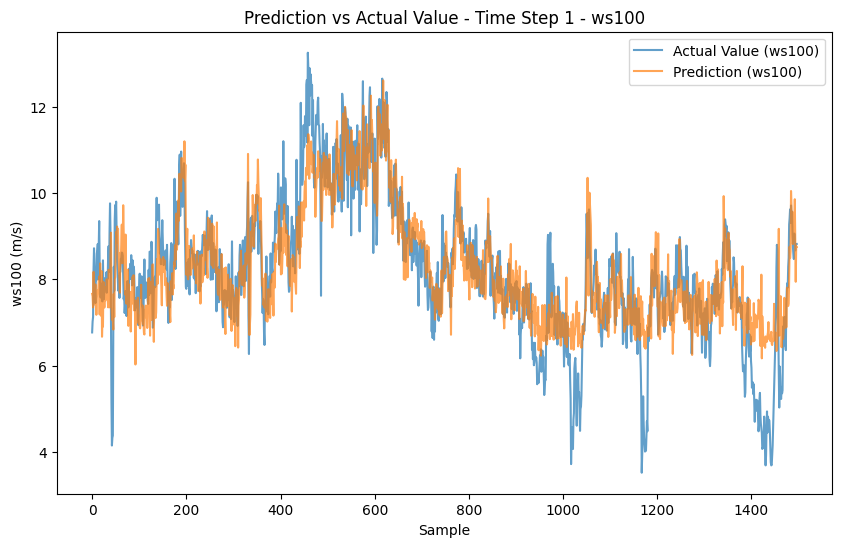

Evaluation for time step 2
'ws100': RMSE = 0.9980, NRMSE = 0.1026, Relative Error = 10.30%


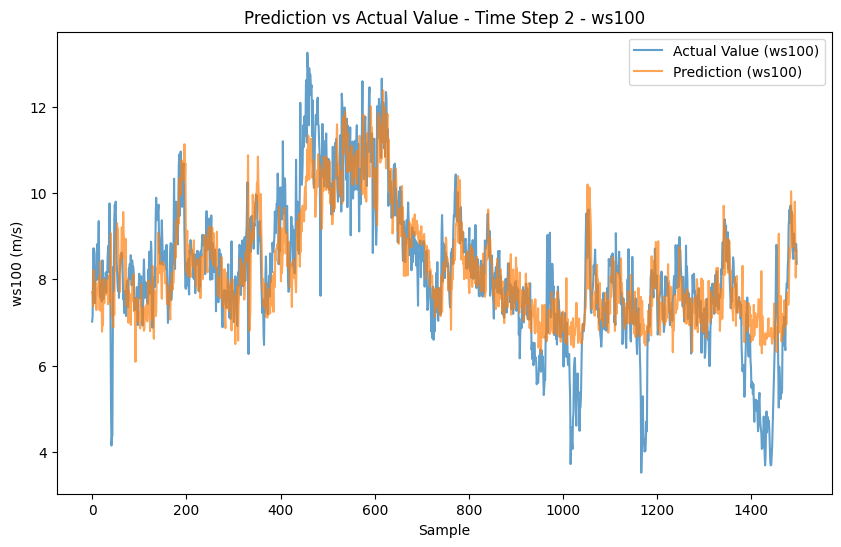

Evaluation for time step 3
'ws100': RMSE = 1.0294, NRMSE = 0.1058, Relative Error = 10.59%


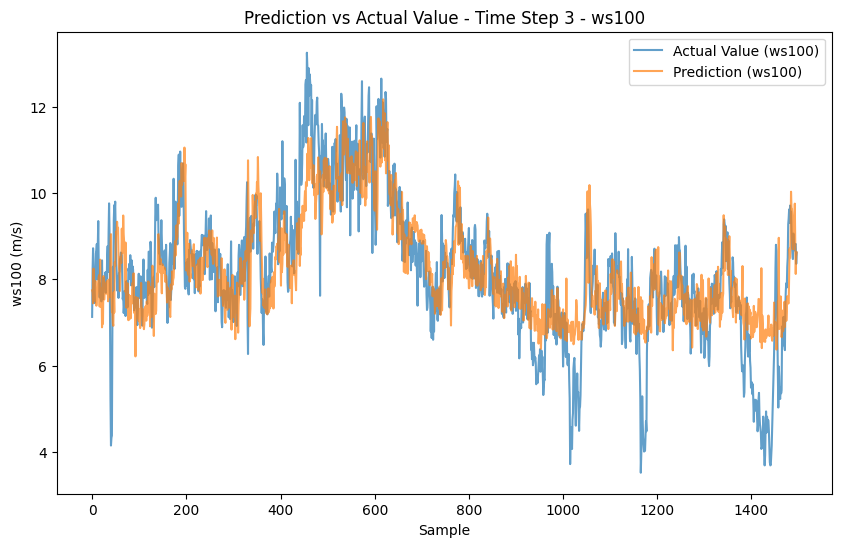

Evaluation for time step 4
'ws100': RMSE = 1.0499, NRMSE = 0.1079, Relative Error = 10.87%


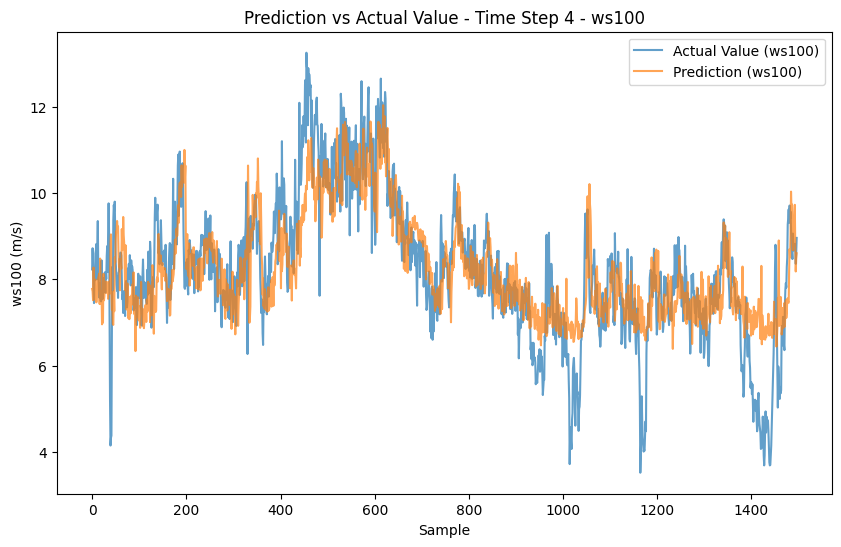

Evaluation for time step 5
'ws100': RMSE = 1.0794, NRMSE = 0.1109, Relative Error = 11.16%


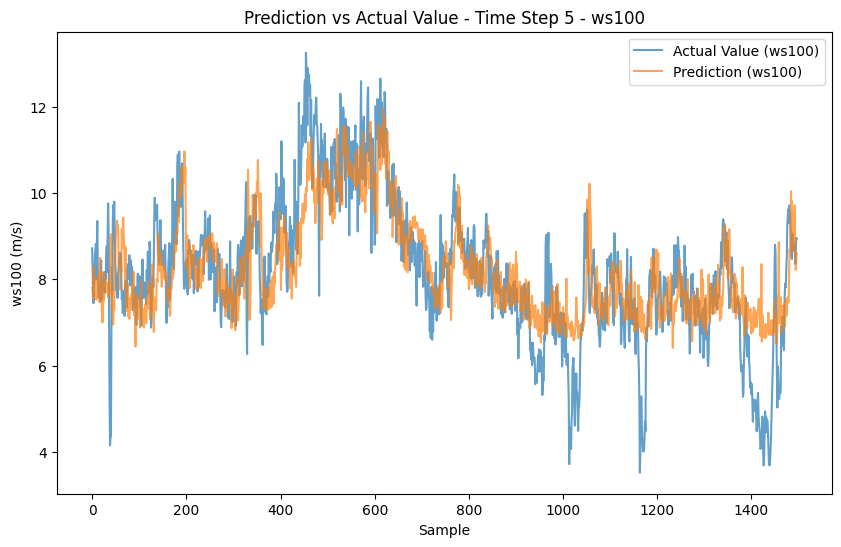

Evaluation for time step 6
'ws100': RMSE = 1.1004, NRMSE = 0.1131, Relative Error = 11.36%


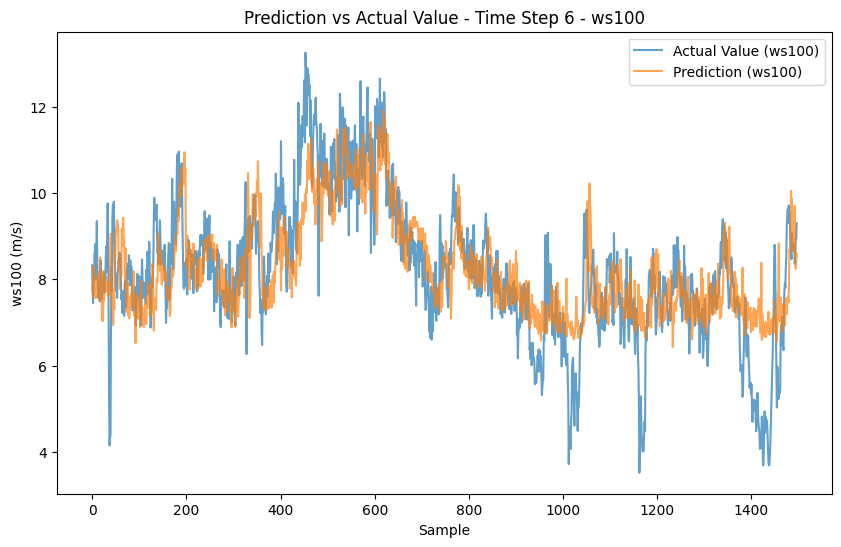

In [ ]:
# Evaluation
for t in range(prediction_length):
    print(f"Evaluation for time step {t+1}")
    
    col = 'ws100'
    y_true = y_test_orig[:, t]      # Shape: [num_samples]
    y_pred_col = y_pred_orig[:, t]  # Shape: [num_samples]

    rmse = np.sqrt(np.mean((y_true - y_pred_col) ** 2))
    nrmse = rmse / (y_true.max() - y_true.min())
    relative_error = np.mean(np.abs((y_true - y_pred_col) / (y_true + 1e-7))) * 100

    print(f"'{col}': RMSE = {rmse:.4f}, NRMSE = {nrmse:.4f}, Relative Error = {relative_error:.2f}%")
    
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label=f"Actual Value ({col})", alpha=0.7)
    plt.plot(y_pred_col, label=f"Prediction ({col})", alpha=0.7)
    plt.legend()
    plt.title(f"Prediction vs Actual Value - Time Step {t+1} - {col}")
    plt.xlabel('Sample')
    plt.ylabel(f'{col} (m/s)')
    plt.show()

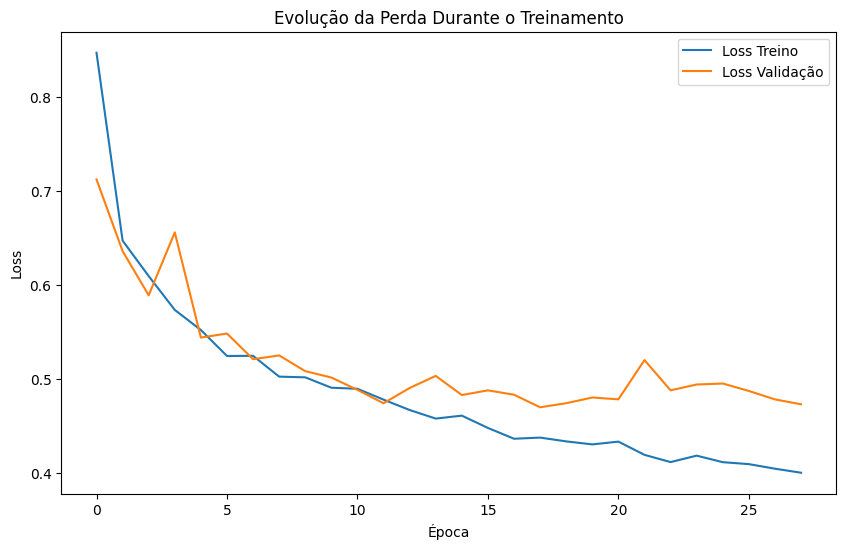

In [ ]:
# Plot da Função de Perda Durante o Treinamento
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.legend()
plt.title('Evolução da Perda Durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.show()

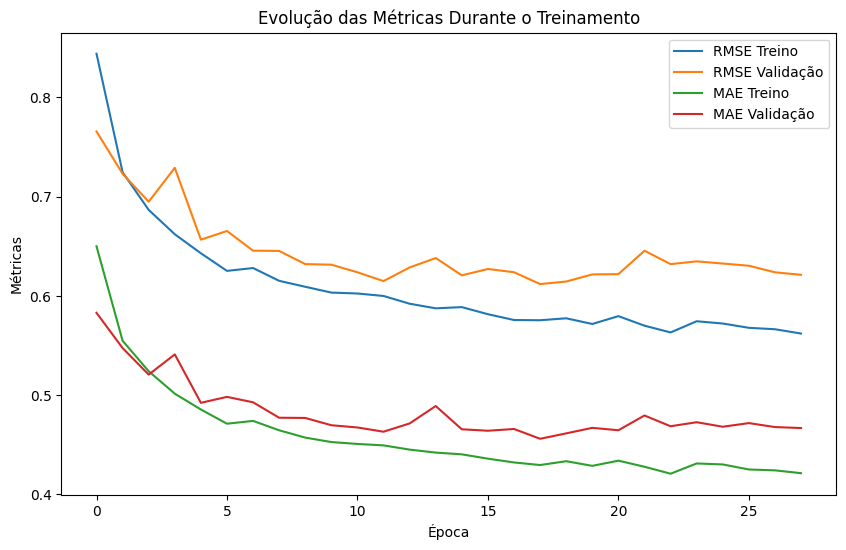

In [ ]:
# Plot das Métricas RMSE e MAE Durante o Treinamento
plt.figure(figsize=(10,6))
plt.plot(history.history['rmse'], label='RMSE Treino')
plt.plot(history.history['val_rmse'], label='RMSE Validação')
plt.plot(history.history['mae'], label='MAE Treino')
plt.plot(history.history['val_mae'], label='MAE Validação')
plt.legend()
plt.title('Evolução das Métricas Durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Métricas')
plt.show()